# MACHINE LEARNING MODEL FOR SALES
---

## Import Library and Read Data

In [1]:
# Libraries:

import matplotlib.colors as col
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
%matplotlib inline

import datetime
from pathlib import Path  
import random
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from pmdarima import auto_arima # for determining ARIMA orders
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
# Returns a pandas dataframe from a csv file.

def load_data(file_name):
    return pd.read_csv(file_name)

In [3]:
'''
    Make a copy of the data so any changes
    made to the original DataFrame will not
    be reflected in the copy.
'''

sales_data = load_data('Dummy Sales 2020-2022.csv')
df = sales_data.copy()                           
df

,id,shop_name,product_name,product_code,product_quantity,unit_price,discount,total_price,order_date,payment_due,payment,payment_date,payment_status,late_payment_status,city,province
0,1,Qhxmkw,Foltus 1L X 20,FOL-35,68,9,16,590,9/23/2020,11/7/2021,590,3/31/2023,False,True,Kabupaten Jepara,Jawa Tengah
1,2,Rfhgqxm,Plethora 250 ML X40,PLE-52,29,16,17,445,6/3/2020,5/25/2021,445,3/29/2023,False,False,Kota Magelang,Jawa Tengah
2,3,Soybau,unused,UNU-64,80,26,4,2094,2/27/2020,9/12/2021,2094,3/29/2023,True,False,Kabupaten Kulon Progo,Daerah Istimewa Yogyakarta
3,4,Ilfbe,Spreader 500 ML X 24,SPR-57,67,2,10,131,12/1/2020,11/28/2021,131,3/31/2023,True,False,Kabupaten Pemalang,Jawa Tengah
4,5,Srwxf,Plethora 250 ML X40,PLE-52,90,36,2,3233,12/13/2020,11/26/2021,3233,3/21/2023,True,True,Kabupaten Sleman,Daerah Istimewa Yogyakarta
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,Xprkjup,CHLORMITE 100 ML X 120,CHL-18,62,38,2,2384,3/5/2022,5/13/2022,2384,3/26/2023,True,False,Kota Yogyakarta,Daerah Istimewa Yogyakarta
9996,9997,Jltguio,Dangke 250 Gr X 40,DAN-27,26,16,4,418,8/6/2022,8/16/2022,418,3/21/2023,False,False,Kabupaten Pekalongan,Jawa Tengah
9997,9998,Rfhgqxm,EXPLORE 80 ML X 36,EXP-34,99,43,4,4253,10/18/2022,1/29/2022,4253,3/31/2023,True,True,Kota Magelang,Jawa Tengah
9998,9999,Pugey,Blasil 100 ml X 100,BLA-13,20,50,4,994,9/29/2022,9/10/2022,994,3/24/2023,True,False,Kabupaten Jepara,Jawa Tengah


---
## Data Understanding

In [4]:
# Check data type

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   10000 non-null  int64 
 1   shop_name            10000 non-null  object
 2   product_name         10000 non-null  object
 3   product_code         10000 non-null  object
 4   product_quantity     10000 non-null  int64 
 5   unit_price           10000 non-null  int64 
 6   discount             10000 non-null  int64 
 7   total_price          10000 non-null  int64 
 8   order_date           10000 non-null  object
 9   payment_due          10000 non-null  object
 10  payment              10000 non-null  int64 
 11  payment_date         10000 non-null  object
 12  payment_status       10000 non-null  bool  
 13  late_payment_status  10000 non-null  bool  
 14  city                 10000 non-null  object
 15  province             10000 non-null  object
dtypes: bo

Check the correct data type by looking at the dtype column and checking for missing values by matching the number of rows and the number of non-null data

In [5]:
'''
    Convert the inappropriate data type:
    order_date, payment_due, payment_date_1 --> datetime
'''

# Convert to datetime
df['order_date'] = pd.to_datetime(df['order_date'], format='%m/%d/%Y')

df['payment_due'] = pd.to_datetime(df['payment_due'], format='%m/%d/%Y')

df['payment_date'] = pd.to_datetime(df['payment_date'], format='%m/%d/%Y')

df['payment'] = round(df['payment']).astype('int64')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   10000 non-null  int64         
 1   shop_name            10000 non-null  object        
 2   product_name         10000 non-null  object        
 3   product_code         10000 non-null  object        
 4   product_quantity     10000 non-null  int64         
 5   unit_price           10000 non-null  int64         
 6   discount             10000 non-null  int64         
 7   total_price          10000 non-null  int64         
 8   order_date           10000 non-null  datetime64[ns]
 9   payment_due          10000 non-null  datetime64[ns]
 10  payment              10000 non-null  int64         
 11  payment_date         10000 non-null  datetime64[ns]
 12  payment_status       10000 non-null  bool          
 13  late_payment_status  10000 non-n

In [7]:
# Generate descriptive statistics of Numeric Data 

pd.options.display.float_format = '{:.5f}'.format  # set the decimal value

nums = ['product_quantity', 'unit_price', 'discount', 'total_price', 'payment']
df[nums].describe()

,product_quantity,unit_price,discount,total_price,payment
count,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000
mean,55.07130,25.33510,10.00310,1382.99340,1382.99340
std,26.19923,14.24139,5.78383,1091.64330,1091.64330
min,5.00000,1.00000,0.00000,2.00000,2.00000
25%,32.00000,13.00000,5.00000,493.00000,493.00000
50%,55.00000,25.00000,10.00000,1089.00000,1089.00000
75%,78.00000,38.00000,15.00000,2056.00000,2056.00000
max,100.00000,50.00000,20.00000,4918.00000,4918.00000


In [8]:
# Generate descriptive statistic of Category Data 


category = ['shop_name', 'city', 'province', 'product_name', 'payment_status', 'late_payment_status']

df[category].describe()

,shop_name,city,province,product_name,payment_status,late_payment_status
count,10000,10000,10000,10000,10000,10000
unique,150,38,2,75,2,2
top,Mvljg,Kabupaten Kulon Progo,Jawa Tengah,Anilo 50 Gr X 100,False,True
freq,92,871,6661,157,5022,5053


In [9]:
# Count of unique values
print('Number of unique values :')
for col in df.columns:
    unique_values = df[col].nunique()
    print(f'"{col}": {unique_values}')

Number of unique values :
"id": 10000
"shop_name": 150
"product_name": 75
"product_code": 75
"product_quantity": 93
"unit_price": 50
"discount": 21
"total_price": 3438
"order_date": 1093
"payment_due": 729
"payment": 3438
"payment_date": 13
"payment_status": 2
"late_payment_status": 2
"city": 38
"province": 2


In [10]:
# Check missing value

print('\033[1m' + 'Amount of missing value in each column :' + '\033[0m')
df.isnull().sum()

Amount of missing value in each column :


id                     0
shop_name              0
product_name           0
product_code           0
product_quantity       0
unit_price             0
discount               0
total_price            0
order_date             0
payment_due            0
payment                0
payment_date           0
payment_status         0
late_payment_status    0
city                   0
province               0
dtype: int64

## Remove Duplicate

In [11]:
# Drop column 'id' from DataFrame
df = df.drop(columns=['id'])

# Check for duplicates except 'id' column
duplicates = df[df.duplicated()]

if duplicates.empty:
    print("No duplicates found!")
else:
    print("Duplicates found: ", duplicates)

No duplicates found!


In [12]:
# Remove Duplicate

df = df.drop_duplicates()

---
## Univariate Analysis
After conducting descriptive statistical analysis, we now focus on one column at a time with Univariate Analysis

In [13]:
# set the graphic display

rcParams['figure.figsize'] = (12, 4)
rcParams['lines.linewidth'] = 3
rcParams['xtick.labelsize'] = 'small'
rcParams['ytick.labelsize'] = 'small'

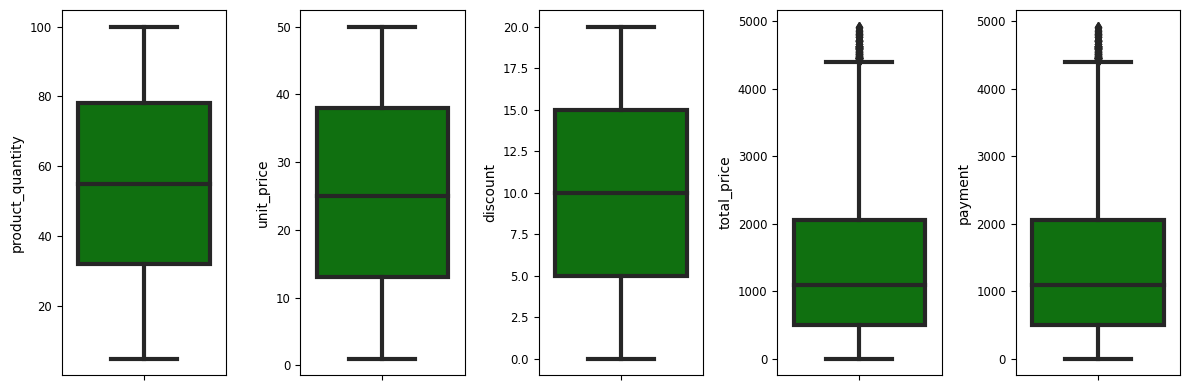

In [14]:
for i in range(0, len(nums)):
    plt.subplot(1, len(nums), i+1)
    sns.boxplot(y=df[nums[i]], color='green', orient='v')
    plt.tight_layout()

The boxplot will show outliers and distributions that look skewed (not symmetrical) which are indicated by the location of the box far from the center of the Y axis.

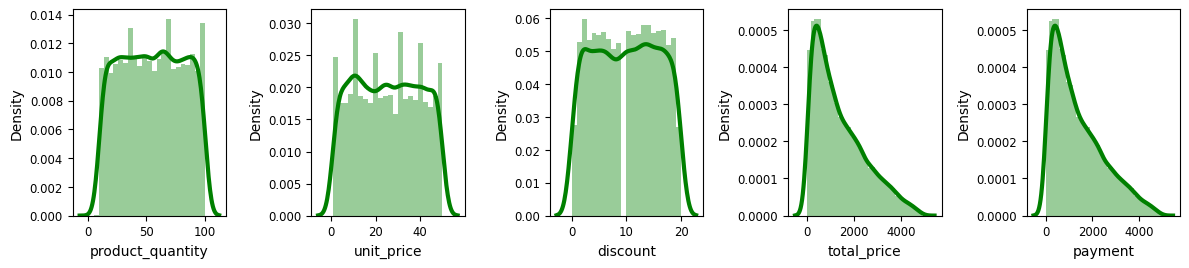

In [15]:
plt.figure(figsize=(12, 5))
for i in range(0, len(nums)):
    plt.subplot(2, len(nums)+1//2, i+1)
    sns.distplot(df[nums[i]], color='green')
    plt.tight_layout()

Distribution plot shows the distribution of data. Data with a skewed distribution may need to be further processed on the columns

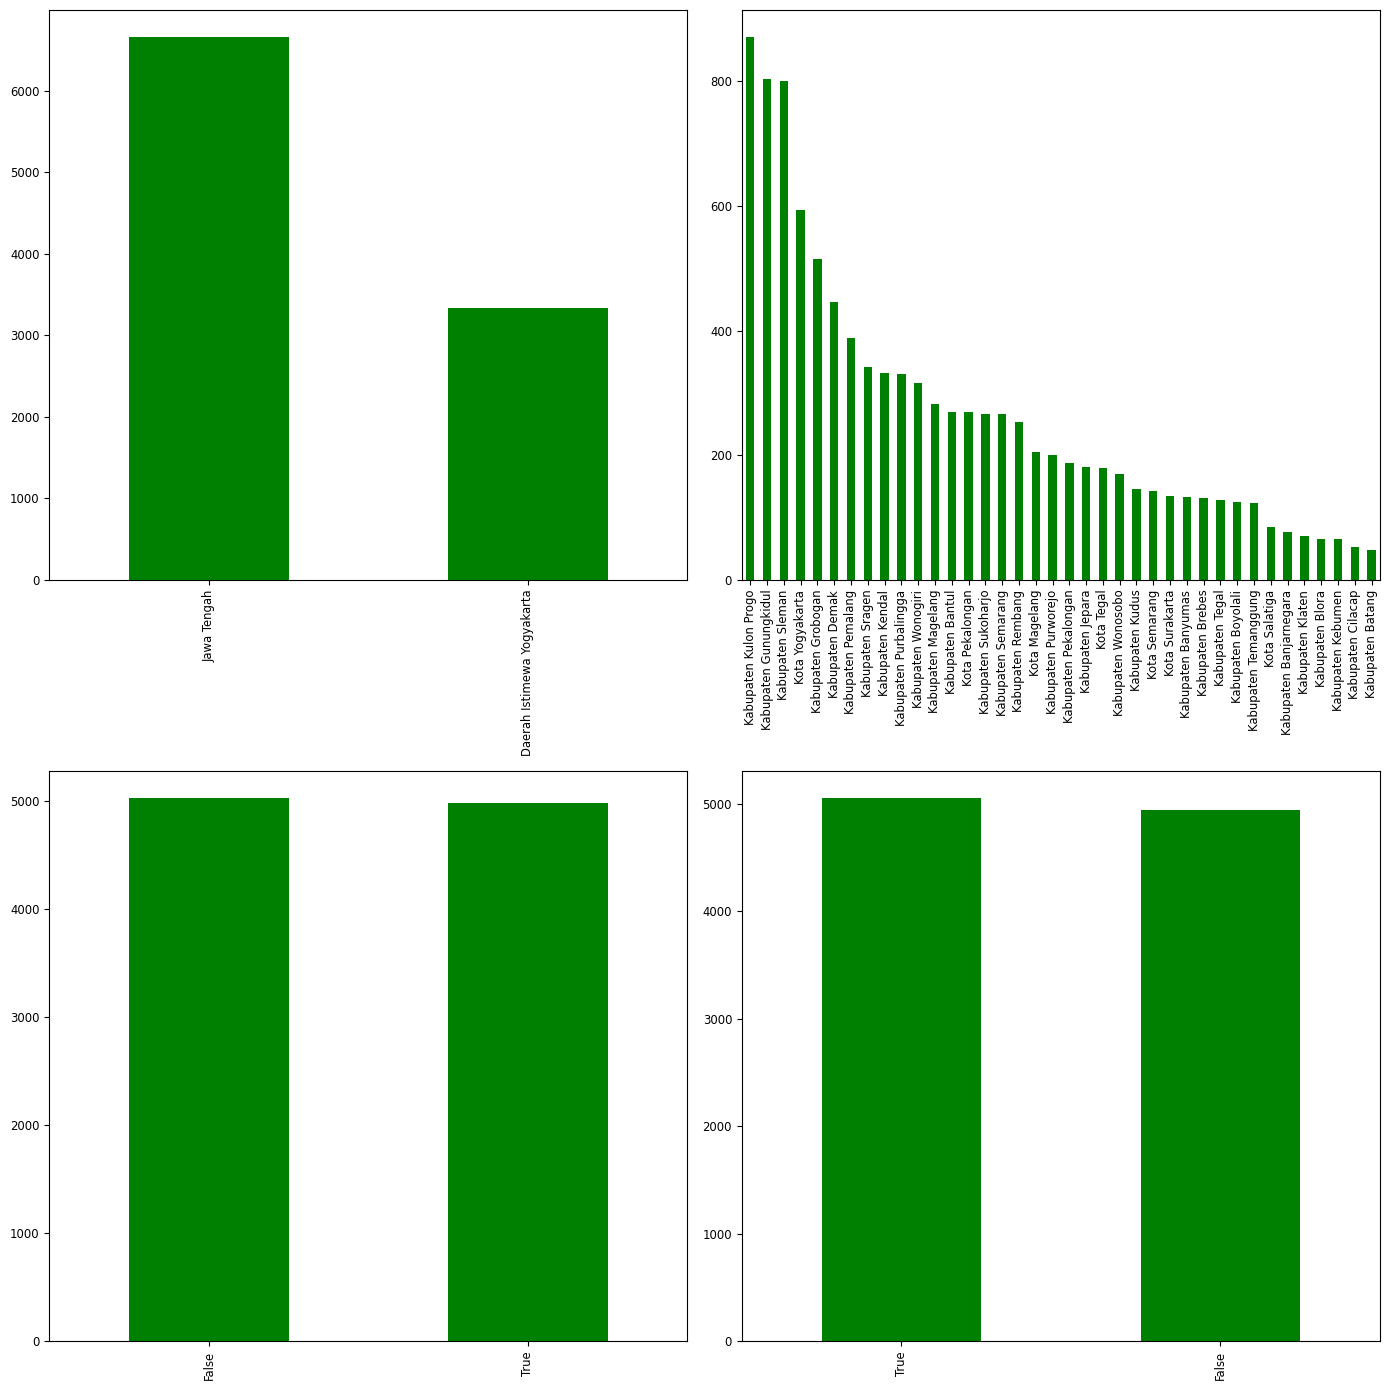

In [16]:
# column containing string values
category_columns = ['province', 'city', 'payment_status', 'late_payment_status']

# Calculates the number of subplots needed
amount_subplot = len(category_columns)
row_subplot = min(amount_subplot, 2)
column_subplot = amount_subplot // 2

# Create subplot
fig, axs = plt.subplots(nrows=row_subplot, ncols=2, figsize=(14, 7*row_subplot))

# Loops to create charts
for i, ax in enumerate(axs.flatten()):
    if i < amount_subplot:
        counts = df[category_columns[i]].value_counts()
        counts.plot(kind='bar', ax=ax, color='green')
    
# Show Chart
plt.tight_layout()
plt.show()

## Bivariate Analysis

bivariate analysis is used for the relationship between columns. Knowing the relationship between columns can help us to select the most important features and ignore redundant features.

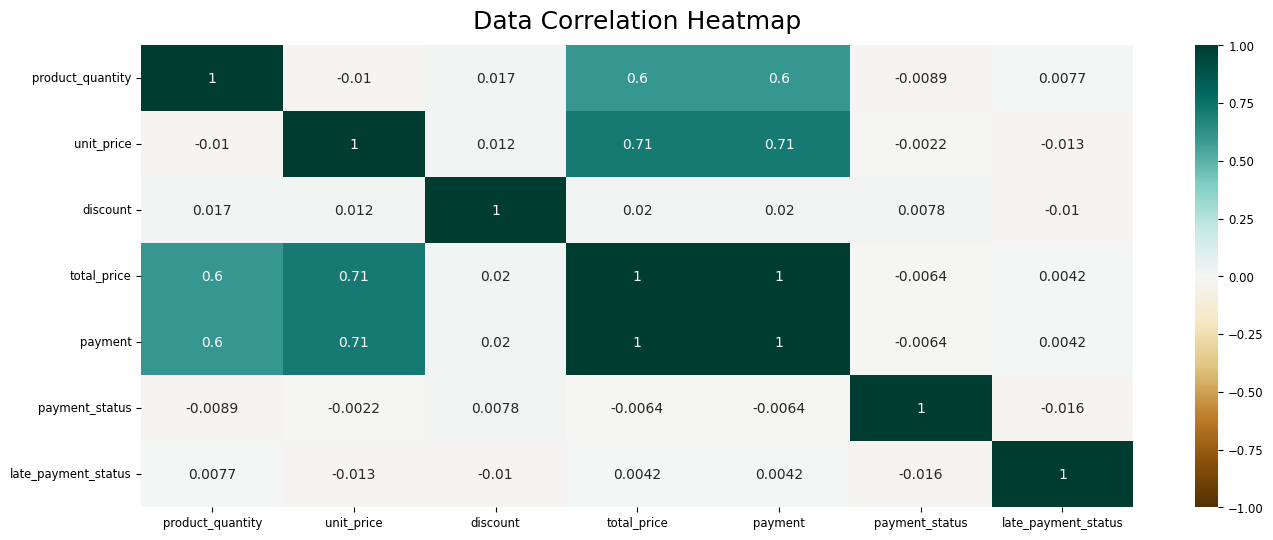

In [17]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Data Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

Features with a correlation of more than 0.6 have the possibility of redundant data

---
## Define the Target

How much **product demand** for the **next 3 months?**

---
## Remove Unnecessary Columns

In [18]:
# Target : 1
cols_to_drop = ['shop_name',
                'city',
                'province',
                'product_name',
                'unit_price',
                'discount',
                'total_price',
                'payment_due',
                'payment_status',
                'payment_date',
                'payment_date',
                'late_payment_status',
                'payment',
                'payment_status']

In [19]:
df = df.drop(cols_to_drop, axis=1)

df

,product_code,product_quantity,order_date
0,FOL-35,68,2020-09-23
1,PLE-52,29,2020-06-03
2,UNU-64,80,2020-02-27
3,SPR-57,67,2020-12-01
4,PLE-52,90,2020-12-13
...,...,...,...
9995,CHL-18,62,2022-03-05
9996,DAN-27,26,2022-08-06
9997,EXP-34,99,2022-10-18
9998,BLA-13,20,2022-09-29


In [20]:
# Sort data by order_date
df = df.sort_values('order_date', ascending=True).reset_index(drop=True)
df

,product_code,product_quantity,order_date
0,KLE-43,48,2020-01-01
1,ANI-5,51,2020-01-01
2,CAL-15,90,2020-01-01
3,FOL-36,95,2020-01-01
4,CHL-21,58,2020-01-01
...,...,...,...
9995,PLE-52,96,2022-12-30
9996,BLA-14,35,2022-12-30
9997,SUP-58,12,2022-12-30
9998,SUP-59,81,2022-12-30


In [21]:
df1 = pd.DataFrame(df.groupby('product_code')['product_quantity'].sum().sort_values(ascending=False))
df1["Contribution (%)"] = df1['product_quantity']/df1['product_quantity'].sum()*100
df1

,product_quantity,Contribution (%)
product_code,,
AGI-1,8949,1.62498
LEI-46,8813,1.60029
ANI-5,8708,1.58122
YAR-67,8674,1.57505
YAR-69,8646,1.56996
...,...,...
NAR-51,6232,1.13162
AVA-8,6181,1.12236
SUP-60,6055,1.09948


In [22]:
# create pivot table
df = pd.pivot_table(df, values='product_quantity', index='order_date', columns='product_code', aggfunc=sum, fill_value=0)

# filter out rows with all zero values
df = df.loc[(df!=0).any(axis=1)]

# print pivot table
df

product_code,AGI-1,AGI-2,ANI-3,ANI-4,ANI-5,AST-6,AST-7,AVA-8,BAL-10,BAL-9,...,YAR-66,YAR-67,YAR-68,YAR-69,YAR-70,YAR-71,YAR-72,YAR-73,YAR-74,ZEN-75
order_date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,0,0,0,0,51,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-02,68,0,0,0,63,0,17,92,24,0,...,73,0,0,0,19,0,0,0,0,0
2020-01-03,0,0,0,0,94,0,0,0,0,0,...,0,30,0,0,0,0,0,15,0,0
2020-01-04,0,91,0,0,0,0,0,0,10,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-05,0,0,100,40,0,95,79,0,0,0,...,34,0,0,26,13,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,35,0,0,0,0,0,0,0,59,68,...,0,0,39,0,41,0,0,0,0,0
2022-12-27,0,0,0,0,51,0,0,0,0,0,...,20,0,0,0,0,0,0,0,0,0
2022-12-28,0,0,0,0,0,0,0,38,0,0,...,0,0,59,0,0,0,0,0,0,0


In [23]:
df = df.resample('M').sum() # Resampling the data on monthly basis 
df.index.freq = "M" # Setting datetime frequency to Month
df

product_code,AGI-1,AGI-2,ANI-3,ANI-4,ANI-5,AST-6,AST-7,AVA-8,BAL-10,BAL-9,...,YAR-66,YAR-67,YAR-68,YAR-69,YAR-70,YAR-71,YAR-72,YAR-73,YAR-74,ZEN-75
order_date,,,,,,,,,,,,,,,,,,,,,
2020-01-31,272,244,240,238,379,254,445,220,348,121,...,163,173,250,101,237,0,171,99,269,212
2020-02-29,185,410,147,170,319,186,182,122,230,119,...,125,190,25,221,76,378,165,166,570,184
2020-03-31,266,186,114,153,143,254,335,191,109,235,...,249,395,148,234,211,202,308,94,263,189
2020-04-30,225,419,157,178,342,103,265,207,23,74,...,83,231,147,110,184,151,246,146,291,255
2020-05-31,180,177,114,0,315,93,224,138,84,328,...,266,252,385,279,291,331,156,101,146,77
2020-06-30,216,236,260,269,361,321,280,0,122,30,...,183,293,87,60,353,40,340,92,152,312
2020-07-31,29,146,193,179,143,264,114,53,139,108,...,292,49,190,337,463,47,0,34,62,101
2020-08-31,336,16,177,308,266,145,196,244,180,89,...,222,17,99,79,87,144,261,125,212,140
2020-09-30,531,199,242,383,199,282,362,111,185,259,...,204,158,186,122,69,141,412,276,40,246


In [24]:
# Enter the product code that you want to predict
Input_Product_Code = input('Please type product code : ')
product_code = f"{Input_Product_Code}"

Please type product code : ANI-5


In [25]:
df = pd.DataFrame(df[product_code].iloc[:-1])
df

,ANI-5
order_date,
2020-01-31,379
2020-02-29,319
2020-03-31,143
2020-04-30,342
2020-05-31,315
2020-06-30,361
2020-07-31,143
2020-08-31,266
2020-09-30,199


In [26]:
span = 4
alpha = 2/(span+1)
df['EWM4'] = df[product_code].ewm(alpha=alpha,adjust=False).mean() # Simple Weighted Moving Average

# Simple Exponentional Smoothing
df['SES4']=SimpleExpSmoothing(df[product_code]).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)

#Double Exponentional Smothening
df['DESadd4'] = ExponentialSmoothing(df[product_code], trend='add').fit().fittedvalues.shift(-1)

<AxesSubplot: xlabel='order_date'>

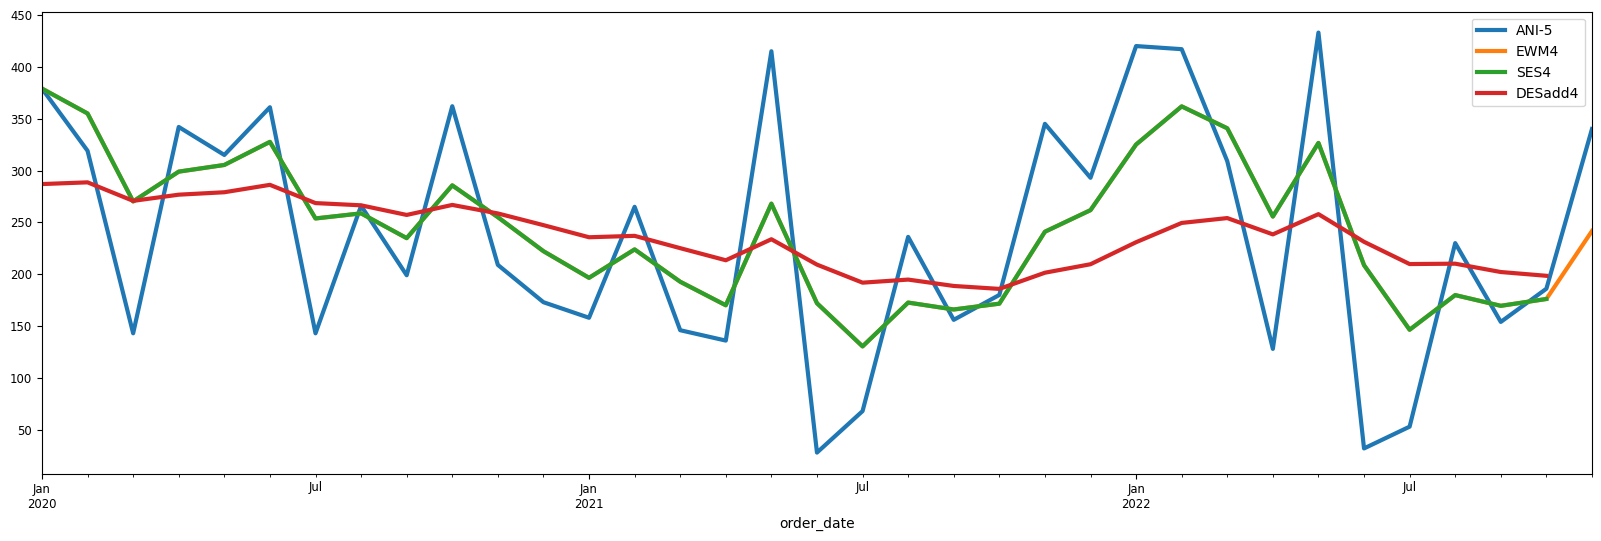

In [27]:
df[[product_code,'EWM4','SES4','DESadd4']].plot(figsize = (20,6)) # Plot for Weighted Moving average & Double Exponentional, 
#It can be seen data has some seasonailty, therefore will use ARIMA, ARMA

In [28]:
# Check data is stationary or not
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','lags used','observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("\nReject the null hypothesis")
        print("Data is stationary")
    else:
        print("\nFail to reject the null hypothesis")
        print("Data is non-stationary")


In [29]:
# Display value in 5 decimals value
pd.options.display.float_format = '{:.5f}'.format

# Call the function adf_test
adf_test(df[product_code])

Augmented Dickey-Fuller Test: 
ADF test statistic     -3.01352
p-value                 0.03365
lags used               4.00000
observations           30.00000
critical value (1%)    -3.66992
critical value (5%)    -2.96407
critical value (10%)   -2.62117

Reject the null hypothesis
Data is stationary


The null hypothesis of the ADF test is that the time series is non-stationary. So, if the _p-value_ of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary.

In [30]:
fit = auto_arima(df[product_code], start_p=1, start_q=1,
                          max_p=5, max_q=5, m=12,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=False,
                          approximation=False)           

fit.summary()

 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=294.208, Time=0.02 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=294.710, Time=0.18 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=294.678, Time=0.18 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=298.455, Time=0.88 sec
 ARIMA(0,0,0)(2,1,2)[12] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=295.679, Time=0.08 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=296.544, Time=0.18 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=296.516, Time=0.23 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=298.456, Time=0.41 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=0.95 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   :

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   35
Model:             SARIMAX(2, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -142.862
Date:                            Thu, 23 Mar 2023   AIC                            293.725
Time:                                    14:36:35   BIC                            298.266
Sample:                                01-31-2020   HQIC                           294.867
                                     - 11-30-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -9.2955     25.206     -0.369      0.712     -58.698      40.107
ar.L1          0.1268      0.203      0.624      0.532      -0.271       0.525
ar.L2          0.3792      0.205      1.850      0.064      -0.023       0.781
sigma2      1.426e+04   5526.554      2.579      0.010    3423.477    2.51e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.62
Prob(Q):                              0.89   Prob(JB):                         0.73
Heteroskedasticity (H):               0.04   Skew:                            -0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

auto_arima will search for the model with the lowest AIC value. The Best model SARIMAX according to Results is SARIMAX(2, 0, 0)x(0, 1, 0, 12).

In [31]:
# Get 80% data

len_df = int(len(df) * 0.8)
len_df

28

In [32]:
# Train & Test Data
train = df[product_code].iloc[:len_df] # train 80% data
test = df[product_code].iloc[len_df:]

In [33]:
# Show train data
train

order_date
2020-01-31    379
2020-02-29    319
2020-03-31    143
2020-04-30    342
2020-05-31    315
2020-06-30    361
2020-07-31    143
2020-08-31    266
2020-09-30    199
2020-10-31    362
2020-11-30    209
2020-12-31    173
2021-01-31    158
2021-02-28    265
2021-03-31    146
2021-04-30    136
2021-05-31    415
2021-06-30     28
2021-07-31     68
2021-08-31    236
2021-09-30    156
2021-10-31    180
2021-11-30    345
2021-12-31    293
2022-01-31    420
2022-02-28    417
2022-03-31    309
2022-04-30    128
Freq: M, Name: ANI-5, dtype: int64

In [34]:
# Show test data
test

order_date
2022-05-31    433
2022-06-30     32
2022-07-31     53
2022-08-31    230
2022-09-30    154
2022-10-31    186
2022-11-30    340
Freq: M, Name: ANI-5, dtype: int64

In [35]:
# Build Model

model = SARIMAX(train,order=(2,0,0), seasonal_order=(0,1,0,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              ANI-5   No. Observations:                   28
Model:             SARIMAX(2, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -102.350
Date:                            Thu, 23 Mar 2023   AIC                            210.699
Time:                                    14:36:35   BIC                            213.017
Sample:                                01-31-2020   HQIC                           210.818
                                     - 04-30-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1176      0.305      0.385      0.700      -0.481       0.716
ar.L2          0.3815      0.303      1.261      0.207      -0.211       0.975
sigma2       2.05e+04   1.42e+04      1.442      0.149   -7372.801    4.84e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.19
Prob(Q):                              0.91   Prob(JB):                         0.55
Heteroskedasticity (H):               0.82   Skew:                            -0.33
Prob(H) (two-sided):                  0.84   Kurtosis:                         1.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
# Build model
start = len(train)
end = len(train) + len(test) - 1
predictions = results.predict(start=start, end=end, dynamic=False).rename('Predicted').astype(int)

# Create a new date range with a monthly frequency
date_range = pd.date_range(start=train.index[-1], periods=len(test), freq='M')

# Set the date range as the index of the predictions dataframe
predictions.index = date_range

# Set the index of the predictions dataframe to match the index of the test data
predictions.index = test.index

In [37]:
# Create a new date range with a monthly frequency
date_range = pd.date_range(start=train.index[-1], periods=len(test), freq='M')

# Set the date range as the index of the predictions dataframe
predictions.index = date_range

# Set the index of the predictions dataframe to match the index of the test data
predictions.index = test.index

# Concatenate predictions and test dataframes horizontally using their indexes
output = pd.concat([test, predictions], axis=1)

# Print the concatenated dataframe
print(output)

            ANI-5  Predicted
order_date                  
2022-05-31    433        476
2022-06-30     32         32
2022-07-31     53         91
2022-08-31    230        240
2022-09-30    154        165
2022-10-31    186        182
2022-11-30    340        349


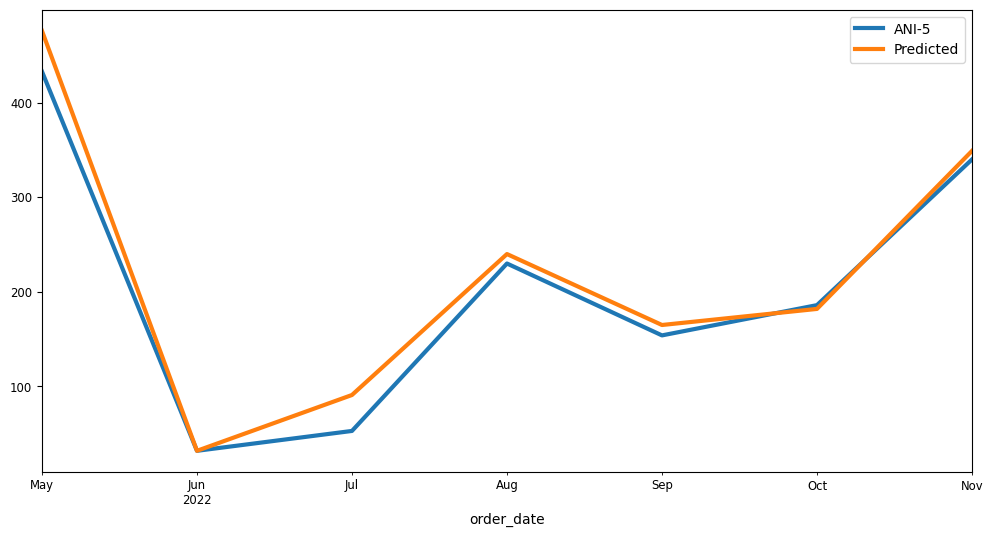

In [38]:
ax = test.plot(legend=True,figsize=(12,6))
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)

#plotting Test data & predicted demand

In [39]:
fcast_month = 5          # forecast for 5 next months
f_1 = fcast_month - 1

# Define the date range for the forecast
start_date = df.index.max() + pd.DateOffset(months=1)
end_date = start_date + pd.DateOffset(months=fcast_month)
forecast_range = pd.date_range(start=start_date, end=end_date, freq='M')

# Retrain the model on the full data, and forecasting for next 4 months
model = SARIMAX(df[product_code],order=(2,0,0),seasonal_order=(0,1,0,12))
results = model.fit()
fcast = results.predict(start=len(df[product_code]), end=len(df[product_code])+f_1, dynamic=False,
                        typ='levels').rename('Predicted').astype(int)

# Set the date range as the index of the forecast
fcast.index = forecast_range

In [40]:
# Show forecast value for the next 5 months
fcast

2022-12-31    294
2023-01-31    418
2023-02-28    417
2023-03-31    308
2023-04-30    128
Freq: M, Name: Predicted, dtype: int32

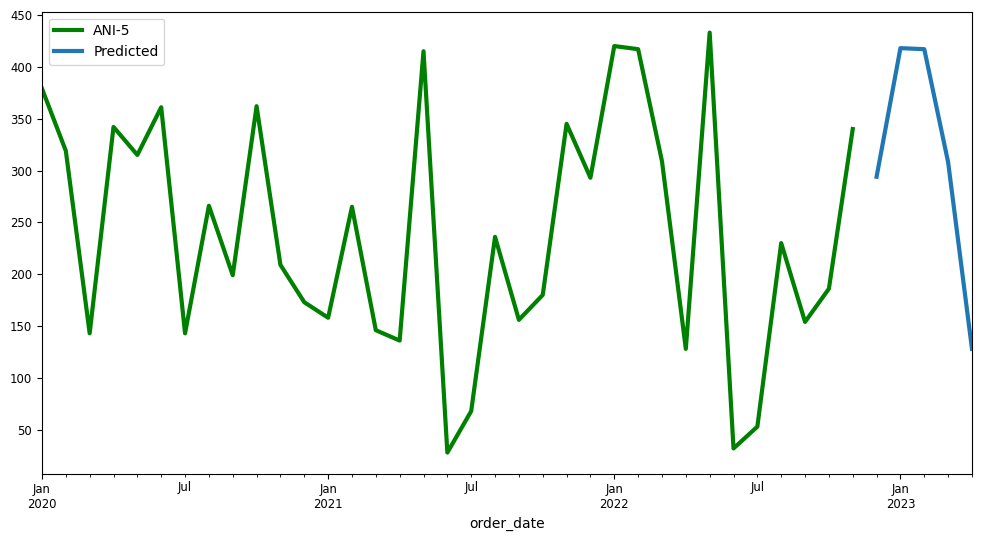

In [41]:
# plotting actual data & 5 month forecasted demand

ax = df[product_code].plot(legend=True, c = 'g', figsize=(12,6))
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)

Same steps need to be done for each category, considering the missing data, stationarity. Finding the best order to be fit into the model and using the train test split to validate the model. Finally forecasting for the required Months.

In [42]:
def forecast_accuracy(predictions, actual):
    mape = (np.mean(np.abs(predictions - actual)/np.abs(actual))) * 100  # MAPE
    me = np.mean(predictions - actual)                                   # ME
    mae = np.mean(np.abs(predictions - actual))     # MAE
    mpe = np.mean((predictions - actual)/actual)   # MPE
    rmse = np.mean((predictions - actual)**2)**.5  # RMSE
    corr = np.corrcoef(predictions, actual)[0,1]   # corr
    mins = np.amin(np.hstack([predictions[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([predictions[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,
            'corr':corr, 'minmax':minmax})

forecast_accuracy(predictions, test)

{'mape': 13.988158404376245,
 'me': 15.285714285714286,
 'mae': 16.428571428571427,
 'mpe': 0.13373719080259502,
 'rmse': 22.712488698008038,
 'corr': 0.9936171086552701,
 'minmax': 0.09479217533280926}

Typically, if you are comparing forecasts of two different series, the MAPE, Correlation and Min-Max Error can be used.

Why not use the other metrics?

Because only the above three are percentage errors that vary between 0 and 1. That way, you can judge how good is the forecast irrespective of the scale of the series.
The other error metrics are quantities. That implies, an RMSE of 100 for a series whose mean is in 1000’s is better than an RMSE of 5 for series in 10’s. So, you can’t really use them to compare the forecasts of two different scaled time series. (https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/)